# Beispiel: Lademanagement eines Speichers für Eigenbedarfsoptimierung

#### Imports

In [1]:
import pandas as pd
import numpy as np

#### Daten lesen

In [2]:
pfad = "PV+Speicher_EV-Opt.xlsx"
data = pd.read_excel(pfad,sheet_name="Aufgabe", names=["t","P_e_rel","P_v"], 
                     usecols="A:C", skiprows=28, parse_dates=['t'])
data=data.set_index('t')
data.P_e_rel = data.P_e_rel/1000

#### Parameter

P_Nenn ... Leistung unter Standard Testbedingungen [W] (oft ugs. [Wp])

C ... Speicherkapazität [Wh]

eta ... Speicherwirkungsgrad 

selb ... Selbstentladung pro Monat 

dt ... Zeitschritt [h]


In [3]:
P_Nenn= 6000
C = 5000
eta = 0.9
selb = 0.05
dt = 1

# Erzeugte Leitstung berechnen
data["P_e"] = data.P_e_rel*P_Nenn

# Differenz erzeugte und verbrauchte Leistung
data["P_diff"] = data.P_v-data.P_e

In [4]:
#data = data.resample('4h').mean()
#dt = 4

<AxesSubplot: xlabel='t', ylabel='P [W]'>

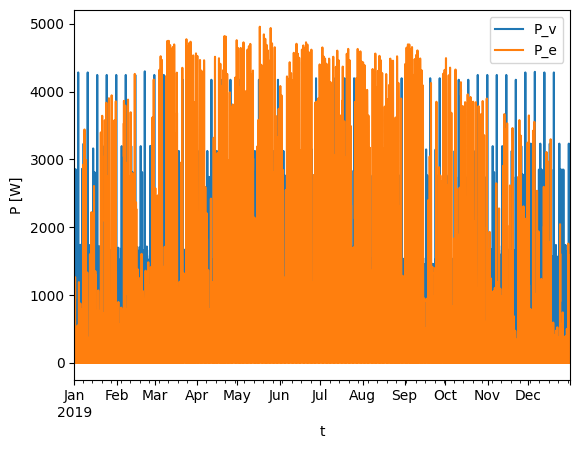

In [5]:
data[["P_v","P_e"]].plot(ylabel = "P [W]")

<AxesSubplot: xlabel='t', ylabel='P [W]'>

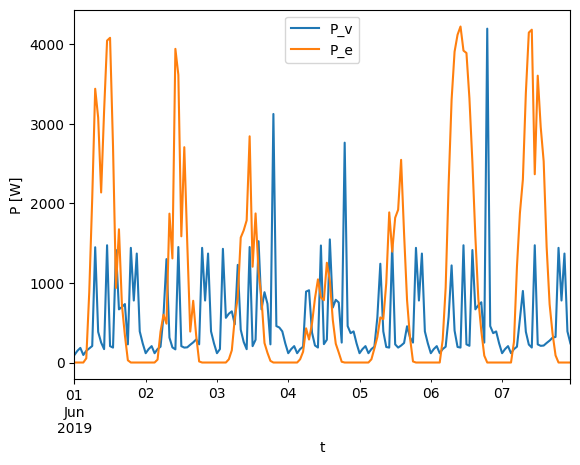

In [6]:
data[["P_v","P_e"]].loc["2019-6-1":"2019-6-7"].plot(ylabel = "P [W]")

<AxesSubplot: xlabel='t', ylabel='P [W]'>

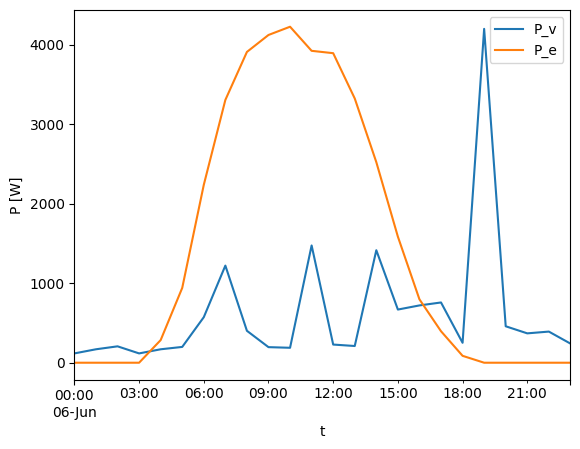

In [7]:
data[["P_v","P_e"]].loc["2019-6-6"].plot(ylabel = "P [W]")

In [8]:
data[["P_v","P_e","P_diff"]].describe()

,P_v,P_e,P_diff
count,8760.000000,8760.000000,8760.000000
mean,570.776256,757.870409,-187.094154
std,588.075830,1266.798097,1395.122175
min,94.782198,0.000000,-4791.718867
25%,210.129012,0.000000,-443.245396
50%,346.897378,0.000000,183.764026
75%,735.409747,927.199952,435.879206
max,4299.908452,4958.351166,4299.908452


#### Simulation

In [9]:
#Selbstentladung pro dt berechnen
P_selb_max = C * selb * 1/30/24 * dt 
#maximale Ladeleistung/Entladeleistung pro dt
P_laden_max = C / dt
#Initialisieren - Anfangswert
Q_alt = 0 
Q_arr = []
P_ein_arr = []
P_aus_arr = []
P_abw_netz_arr = []
P_abw_ein_arr = []

for t in data.index:
    P_selb = np.min([P_selb_max, data.P_e.loc[t]])
    P_soll = data.P_v.loc[t] - data.P_e.loc[t]
    if P_soll <= 0:
        P_ein = np.min([-P_soll, P_laden_max, (C-Q_alt+P_selb*dt)/(eta*dt)])
        P_aus = 0
        P_abw_ein = - P_soll - P_ein
        P_abw_netz = 0
        Q_neu = Q_alt + eta * P_ein * dt
    else:
        P_aus = np.min([P_soll, P_laden_max, Q_alt/dt])
        P_ein = 0
        P_abw_netz = P_soll - P_aus
        P_abw_ein = 0
        Q_neu = Q_alt - P_aus * dt
    Q_neu = np.max([Q_neu - P_selb * dt, 0])
    Q_arr.append(Q_neu)
    P_ein_arr.append(P_ein)
    P_aus_arr.append(P_aus)
    P_abw_netz_arr.append(P_abw_netz)
    P_abw_ein_arr.append(P_abw_ein)

    Q_alt = Q_neu
    


results = pd.DataFrame({"Q":Q_arr, "P_ein":P_ein_arr, "P_aus":P_aus_arr, 
                        "P_netz":P_abw_netz_arr, "P_einsp":P_abw_ein_arr}, index = data.index)
results["P_direkt"] = data[["P_v","P_e"]].min(axis=1)

#### Validierungs Check

<AxesSubplot: xlabel='t', ylabel='Q [Wh]'>

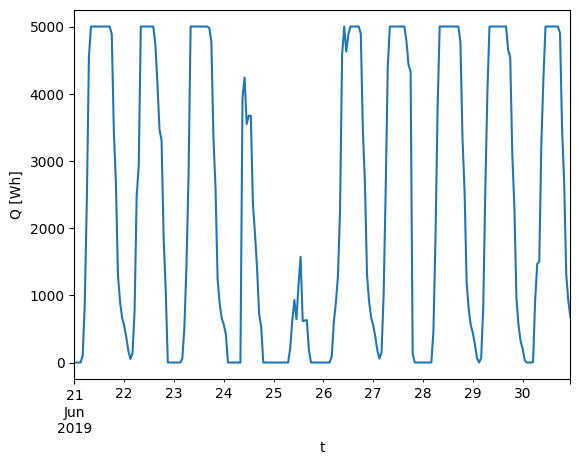

In [10]:
results.Q.loc["2019-6-21":"2019-6-30"].plot(ylabel = "Q [Wh]")

<AxesSubplot: xlabel='t', ylabel='P [W]'>

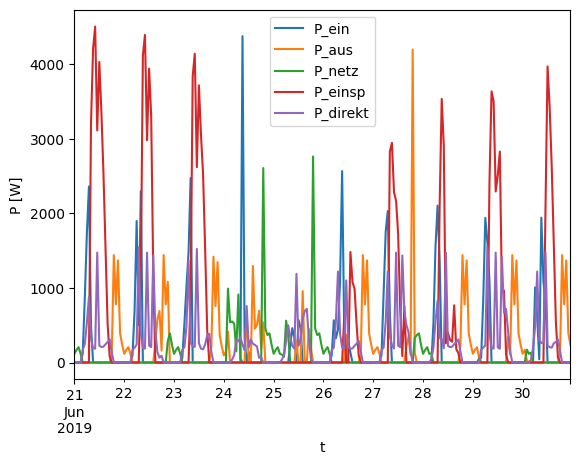

In [11]:
results[["P_ein", "P_aus", "P_netz", "P_einsp", "P_direkt"]].loc["2019-6-21":"2019-6-30"].plot(ylabel = "P [W]")

<AxesSubplot: title={'center': 'Monatsmittelwerte'}, xlabel='t', ylabel='P[W]'>

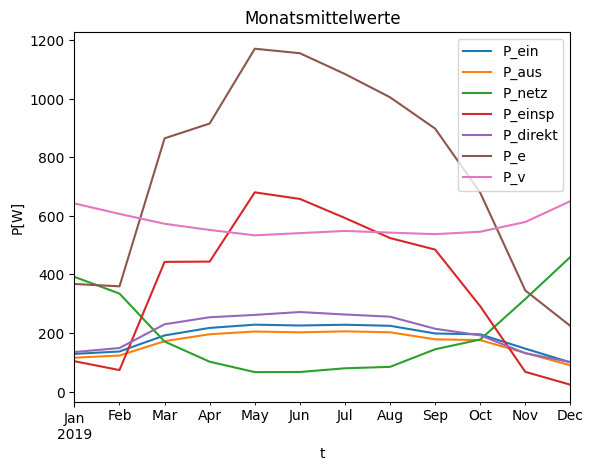

In [12]:
ax = results[["P_ein", "P_aus", "P_netz", "P_einsp", "P_direkt"]].resample('m').mean().plot()
data[["P_e", "P_v"]].resample('m').mean().plot(ax=ax, ylabel="P[W]", title = "Monatsmittelwerte")

#### Monatssummen in kWh

In [13]:
results[["P_ein", "P_aus", "P_netz", "P_einsp", "P_direkt"]].resample('m').sum().multiply(dt/1000)

,P_ein,P_aus,P_netz,P_einsp,P_direkt
t,,,,,
2019-01-31,95.728494,86.096964,291.370271,77.171498,100.383589
2019-02-28,92.018420,82.751995,224.760623,49.402623,100.018256
2019-03-31,142.688754,128.066943,127.105966,329.406788,171.003448
2019-04-30,156.530943,141.007832,73.465598,319.477565,182.717054
2019-05-31,169.966878,152.543490,49.528158,505.931511,194.750606
2019-06-30,162.446419,145.669197,48.198872,473.498008,195.564345
2019-07-31,169.791924,153.010800,59.221870,440.864556,195.786364
2019-08-31,167.130745,150.618813,62.831373,389.958108,190.238467
2019-09-30,142.829510,128.435101,104.004481,348.988871,154.450374


In [14]:
data[["P_v", "P_e"]].resample('m').sum().multiply(dt/1000)

,P_v,P_e
t,,
2019-01-31,477.850825,273.283582
2019-02-28,407.530873,241.439298
2019-03-31,426.176356,643.098989
2019-04-30,397.190484,658.725561
2019-05-31,396.822254,870.648996
2019-06-30,389.432414,831.508772
2019-07-31,408.019033,806.442843
2019-08-31,403.688654,747.327320
2019-09-30,386.889956,646.268756


In [15]:
results[["P_ein", "P_aus", "P_netz", "P_einsp", "P_direkt"]].sum().multiply(dt/1000)

P_ein       1624.427022
P_aus       1460.757201
P_netz      1742.201988
P_einsp     3217.476953
P_direkt    1797.040811
dtype: float64

In [16]:
data[["P_v", "P_e"]].sum().multiply(dt/1000)

P_v    5000.000000
P_e    6638.944786
dtype: float64

#### KPIs

Eigenverbrauch in kWh

In [17]:
ev = (data.P_v.sum()-results.P_netz.sum())*dt/1000
ev

3257.798011832796

Eigenverbrauchsquote EVQ

In [18]:
ev/(data.P_e.sum()*dt/1000)

0.49071021328863385

Solarer Deckungsgrad SDQ

In [19]:
ev/(data.P_v.sum()*dt/1000)

0.6515596023664897

Ladezyklen

In [20]:
results.P_aus.sum()*dt/C

292.151440251396